In [1]:
import numpy as np
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
from astropy.table import Table
from astropy.stats import sigma_clip
from SED_Model import lrt_model
import matplotlib.pyplot as plt

### Functions

In [2]:
#This function uses the AGN SED from Assef et al. (2010) and codes to calculate the M_i as a function of redshift for a fixed i-band observed magnitude. It also adds a correction to exactly match the M_i reported for the object at its spec redshift to account for the fact that other templates were used. 
def get_Mi_z(m_i, zs, Mi_catalog=None, z_catalog=None):
    gal = lrt_model()
    gal.comp = np.zeros(4)
    gal.comp[0] = 1.0
    gal.ebv = 0.
    gal.igm = 1.0
    norm = 0
    if Mi_catalog is not None:   
        gal.zspec = z_catalog
        gal.comp[0] = 1.0
        gal.get_model_fluxes()
        gal.comp[0] *= 3631.*10.**(-0.4*m_i)/gal.jymod[0]
        norm = gal.abs_mag[0] - Mi_catalog

    Mi_z = np.zeros(zs.shape)
    for k,z in enumerate(zs):
        gal.zspec = z
        gal.comp[0] = 1.0
        gal.get_model_fluxes()
        gal.comp[0] *= 3631.*10.**(-0.4*m_i)/gal.jymod[0]
        Mi_z[k] = gal.abs_mag[0] - norm
    return Mi_z

In [3]:
#This function separates the lightcurve in epochs and runs a sigma clip in each epoch to clean them. 
def mask_lc(lc, sigma):
    dt_next_obs = lc['mjd'][1:] - lc['mjd'][:-1]
    lc_mask = np.zeros(len(lc['mjd']), dtype=bool)
    epoch_indices = np.argwhere(dt_next_obs>170)
    for i in range(len(epoch_indices)+1):
        if i==0:
            kmin = 0
            kmax = epoch_indices[i][0]+1
        elif i==len(epoch_indices):
            kmin = epoch_indices[i-1][0]+1
            kmax = -1
        else:
            kmin = epoch_indices[i-1][0]+1
            kmax = epoch_indices[i][0]+1
        lc_mask[kmin:kmax] = sigma_clip(lc['psMag'][kmin:kmax], sigma, masked=True, cenfunc='median').mask
    return lc[~lc_mask]

In [4]:
#Function from Macleod et al. (2010), calibration without M_BH.
def get_tau_M10(Mi, z):
    lam_RF = 6231./(1+z)
    A, B, C = (2.2, 0.17, -0.01)
    return 10.**(A+B*np.log10(lam_RF/4000.)+C*(Mi+23)) 

In [5]:
#Function from Macleod et al. (2010), calibration without M_BH. Note that this gives you sigma in magnitudes, and we are getting it in fluxes.
def get_sigma_M10(Mi, z):
    lam_RF = 6231./(1+z)
    A, B, C = (-0.618, -0.479, 0.09)
    return 10.**(A+B*np.log10(lam_RF/4000.)+C*(Mi+23)) / 2**0.5

### Start of the main code

In [6]:
#Basic parameters and arrays we need. 
fnames = [
    "object1415792.dat",
    "object1444606.dat",
    "object1464480.dat",
    "object1465497.dat",
]
Mis = [
    -24.156505,
    -25.624948,
    -24.113255,
    -23.645797,
]
mis = [
    19.600380,
    18.095129,
    19.697819,
    20.086670,
]
zs = np.zeros(len(Mis))
mean_f = np.zeros(len(Mis))

In [7]:
#Process each lightcurve.
for i, fname in enumerate(fnames):
    lc = Table.read(fname, format='ascii')
    lc.sort('mjd')

    #Remove early data
    lc = lc[lc['mjd']>53500]

    #Set the redshift
    zs[i] = lc['z'][0]

    #Mask the lightcurve
    lc_masked = mask_lc(lc, sigma=2.5)

    #Get the mean flux. We will need it to convert the sigma from magnitude to flux.
    mean_f[i] = np.mean(lc_masked['psFlux']/1e4)

    #Save the light curve in the format Javelin needs.
    np.savetxt("lc{}.dat".format(i), np.array([lc_masked['mjd']-np.min(lc_masked['mjd']), lc_masked['psFlux']/1e4, lc_masked['psFluxErr']/1e4]).T)

start burn-in
nburn: 50 nwalkers: 200 --> number of burn-in iterations: 10000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.73 0.70 0.71 0.68 0.72 0.62 0.72 0.69 0.69 0.77 0.62 0.66 0.68 0.71 0.70 0.72 0.73 0.79 0.75 0.72 0.69 0.69 0.75 0.69 0.72 0.73 0.71 0.71 0.72 0.77 0.66 0.66 0.65 0.71 0.74 0.70 0.72 0.68 0.68 0.69 0.73 0.66 0.71 0.68 0.69 0.73 0.69 0.67 0.72 0.64 0.71 0.74 0.70 0.78 0.72 0.69 0.72 0.72 0.68 0.74 0.70 0.71 0.68 0.70 0.65 0.70 0.71 0.69 0.67 0.66 0.64 0.72 0.78 0.71 0.73 0.70 0.73 0.77 0.61 0.70 0.62 0.68 0.69 0.74 0.73 0.69 0.76 0.72 0.69 0.73 0.77 0.66 0.67 0.74 0.73 0.70 0.70 0.66 0.72 0.70 0.71 0.66 0.70 0.70 0.68 0.77 0.76 0.72 0.72 0.69 0.71 0.71 0.77 0.70 0.76 0.74 0.74 0.72 0.69 0.69 0.72 0.71 0.69 0.76 0.74 0.71 0.66 0.69 0.74 0.74 0.68 0.72 0.79 0.64 0.74 0.81 0.70 0.72 0.69 0.68 0.65 0.77 0.72 0.71 0.77 0.76 0.67 0.72 0.72 0.72 0.73 0.69 0.77 0.73 0.69 0.69 0.74 0.71 0.74 0.66 0.69 0.73 0.75 0.72 0.70 0.76 0

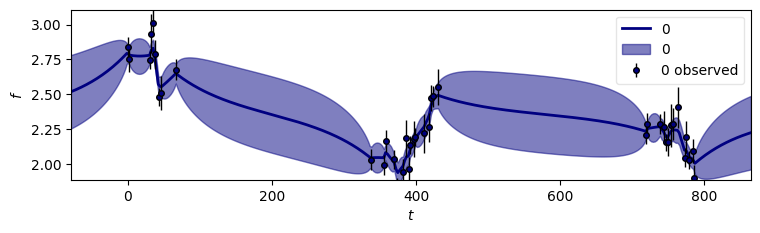

start burn-in
nburn: 50 nwalkers: 200 --> number of burn-in iterations: 10000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.67 0.72 0.73 0.65 0.72 0.66 0.73 0.68 0.67 0.67 0.69 0.72 0.73 0.61 0.70 0.74 0.66 0.72 0.64 0.70 0.69 0.69 0.71 0.71 0.73 0.65 0.69 0.67 0.69 0.72 0.71 0.69 0.75 0.73 0.68 0.65 0.74 0.78 0.69 0.66 0.73 0.76 0.70 0.79 0.69 0.72 0.72 0.70 0.69 0.63 0.69 0.77 0.72 0.69 0.71 0.69 0.67 0.70 0.68 0.68 0.69 0.71 0.69 0.70 0.72 0.69 0.73 0.66 0.74 0.72 0.72 0.69 0.69 0.73 0.65 0.75 0.72 0.70 0.69 0.69 0.73 0.72 0.72 0.67 0.67 0.68 0.72 0.69 0.67 0.62 0.79 0.73 0.69 0.72 0.67 0.70 0.68 0.74 0.66 0.77 0.71 0.76 0.71 0.63 0.69 0.70 0.77 0.72 0.71 0.69 0.74 0.73 0.73 0.72 0.66 0.72 0.74 0.72 0.73 0.74 0.72 0.77 0.70 0.70 0.65 0.77 0.72 0.71 0.73 0.76 0.72 0.70 0.74 0.70 0.62 0.66 0.69 0.72 0.78 0.71 0.80 0.72 0.66 0.70 0.73 0.68 0.67 0.71 0.64 0.71 0.71 0.59 0.74 0.76 0.69 0.70 0.74 0.72 0.73 0.68 0.72 0.72 0.68 0.72 0.73 0.73 0

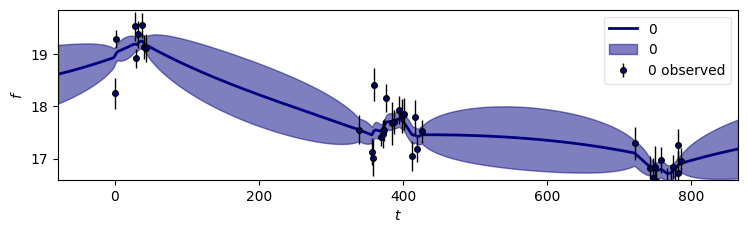

start burn-in
nburn: 50 nwalkers: 200 --> number of burn-in iterations: 10000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.61 0.70 0.78 0.61 0.69 0.73 0.73 0.72 0.68 0.68 0.66 0.73 0.74 0.72 0.72 0.69 0.71 0.70 0.67 0.70 0.78 0.69 0.62 0.77 0.70 0.71 0.73 0.75 0.68 0.71 0.71 0.75 0.73 0.77 0.70 0.77 0.70 0.71 0.77 0.67 0.67 0.70 0.67 0.66 0.74 0.69 0.72 0.66 0.70 0.66 0.72 0.68 0.74 0.73 0.72 0.76 0.73 0.66 0.75 0.72 0.70 0.71 0.71 0.64 0.65 0.73 0.71 0.68 0.71 0.76 0.63 0.72 0.64 0.72 0.69 0.74 0.70 0.68 0.72 0.73 0.65 0.65 0.69 0.77 0.66 0.74 0.74 0.65 0.70 0.72 0.70 0.70 0.76 0.72 0.69 0.69 0.74 0.74 0.72 0.75 0.70 0.68 0.72 0.69 0.69 0.71 0.70 0.69 0.74 0.69 0.68 0.71 0.72 0.72 0.79 0.69 0.67 0.64 0.65 0.73 0.68 0.71 0.73 0.81 0.70 0.72 0.71 0.72 0.73 0.70 0.78 0.69 0.67 0.66 0.74 0.74 0.71 0.74 0.69 0.67 0.73 0.76 0.69 0.64 0.66 0.68 0.69 0.67 0.70 0.70 0.68 0.74 0.73 0.72 0.74 0.74 0.62 0.71 0.68 0.69 0.66 0.74 0.73 0.73 0.73 0.59 0

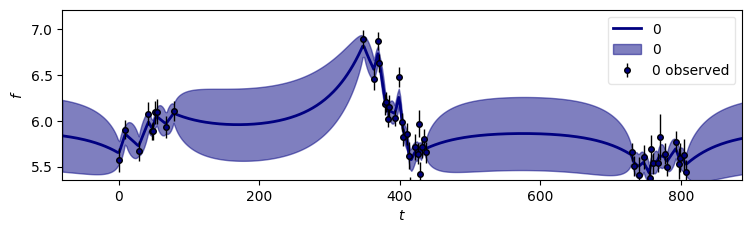

start burn-in
nburn: 50 nwalkers: 200 --> number of burn-in iterations: 10000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.77 0.69 0.70 0.61 0.75 0.77 0.74 0.68 0.72 0.70 0.69 0.73 0.76 0.74 0.79 0.76 0.69 0.69 0.66 0.76 0.69 0.74 0.69 0.70 0.71 0.71 0.71 0.67 0.74 0.74 0.81 0.72 0.72 0.68 0.72 0.72 0.68 0.69 0.70 0.66 0.70 0.68 0.65 0.77 0.74 0.72 0.70 0.68 0.65 0.64 0.74 0.68 0.69 0.73 0.77 0.73 0.69 0.73 0.66 0.76 0.76 0.74 0.67 0.73 0.72 0.71 0.66 0.73 0.76 0.62 0.69 0.70 0.68 0.69 0.67 0.77 0.69 0.72 0.70 0.73 0.72 0.68 0.65 0.66 0.74 0.66 0.69 0.67 0.69 0.72 0.69 0.73 0.72 0.72 0.78 0.78 0.66 0.69 0.70 0.73 0.71 0.74 0.67 0.77 0.77 0.70 0.69 0.75 0.74 0.72 0.68 0.68 0.72 0.70 0.71 0.69 0.65 0.67 0.74 0.70 0.71 0.69 0.69 0.67 0.77 0.70 0.74 0.78 0.67 0.68 0.78 0.73 0.72 0.72 0.74 0.74 0.64 0.66 0.74 0.69 0.70 0.71 0.70 0.74 0.78 0.81 0.74 0.72 0.73 0.73 0.68 0.70 0.71 0.75 0.74 0.65 0.73 0.60 0.70 0.72 0.72 0.62 0.69 0.76 0.67 0.68 0

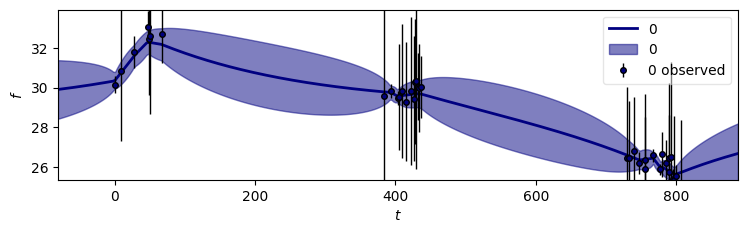

In [8]:
#Run the modeling.

#Array to save HPD results.
hpd = np.zeros((len(fnames), 3, 2))


for i, fname in enumerate(fnames):

    #Run the model
    c = get_data(["lc{}.dat".format(i)])
    cmod = Cont_Model(c)
    cmod.do_mcmc(nwalkers=200, nchain=200)
    hpd[i] = cmod.hpd
    print(cmod.hpd)

    #Plot the fit. 
    lc_best = cmod.do_pred(cmod.hpd[1,:])
    lc_best.plot(set_pred=True, obs=c)

    #Save the MCMC chain
    if i==0:
        flatchain = np.zeros((4, cmod.flatchain.shape[0], cmod.flatchain.shape[1]))
    flatchain[i] = cmod.flatchain

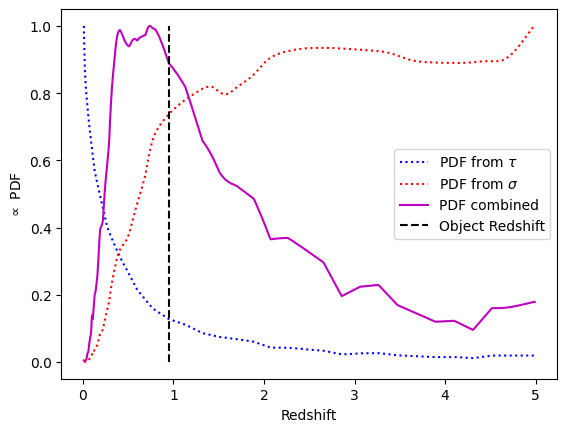

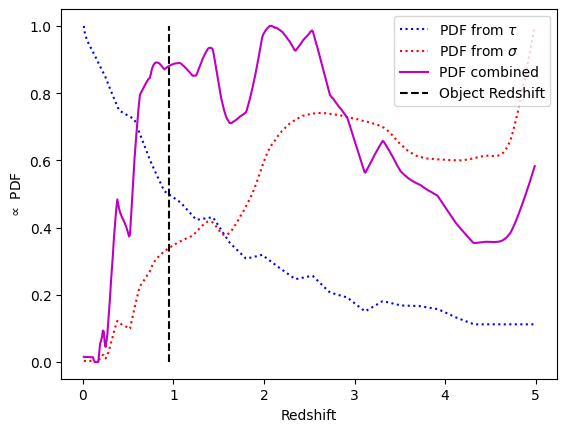

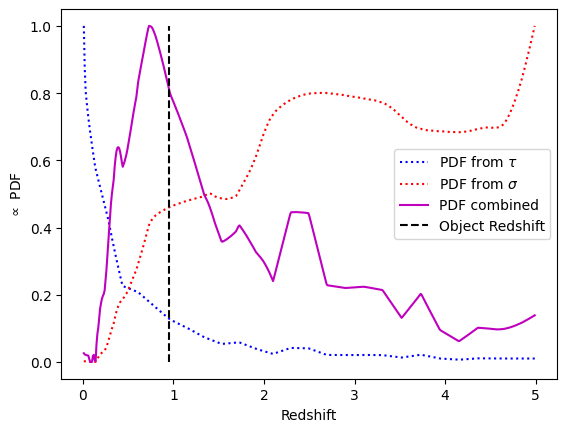

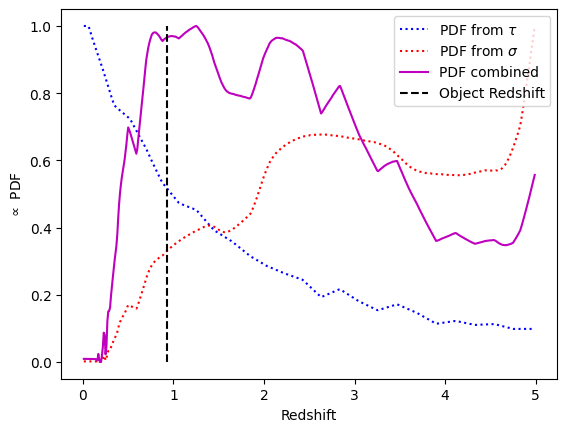

In [9]:
#Plot the results.

z_test = np.arange(0.01, 5., 0.01)
for i in range(4):
    Mi_z = get_Mi_z(mis[i], z_test, Mis[i], zs[i])
    tau_test = get_tau_M10(Mi_z, z_test) * (1+z_test)
    sigma_test = get_sigma_M10(Mi_z, z_test) * 0.4*np.log(10.) * mean_f[i]

    dens_tau_pdf_binned, bins_tau = np.histogram(np.exp(flatchain[i,:,1]), bins=30)
    tau_pdf = 0.5*(bins_tau[1:]+bins_tau[:-1])
    dens_tau_pdf = np.interp(tau_test, tau_pdf, dens_tau_pdf_binned)/flatchain.shape[1]
    plt.plot(z_test, dens_tau_pdf/np.max(dens_tau_pdf), 'b:', label=r'PDF from $\tau$')

    dens_sigma_pdf_binned, bins_sigma = np.histogram(np.exp(flatchain[i,:,0]), bins=30)
    sigma_pdf = 0.5*(bins_sigma[1:]+bins_sigma[:-1])
    dens_sigma_pdf = np.interp(sigma_test, sigma_pdf, dens_sigma_pdf_binned)/flatchain.shape[1]
    plt.plot(z_test, dens_sigma_pdf/np.max(dens_sigma_pdf), 'r:', label=r'PDF from $\sigma$')

    plt.plot(z_test, dens_sigma_pdf*dens_tau_pdf/np.max(dens_sigma_pdf*dens_tau_pdf), 'm-', label='PDF combined')

    plt.plot([zs[i], zs[i]],[0.,1.], 'k--', label='Object Redshift')
    plt.xlabel('Redshift')
    plt.ylabel(r'$\propto$ PDF')

    plt.legend()

    plt.show()

start burn-in
nburn: 50 nwalkers: 200 --> number of burn-in iterations: 10000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.75 0.71 0.76 0.70 0.70 0.70 0.70 0.71 0.72 0.77 0.72 0.72 0.69 0.79 0.68 0.68 0.68 0.68 0.81 0.68 0.73 0.68 0.66 0.68 0.72 0.70 0.67 0.69 0.75 0.65 0.69 0.69 0.70 0.79 0.77 0.72 0.75 0.71 0.69 0.73 0.74 0.77 0.71 0.72 0.72 0.74 0.75 0.62 0.75 0.68 0.79 0.69 0.70 0.70 0.72 0.73 0.71 0.71 0.78 0.69 0.66 0.71 0.64 0.71 0.68 0.77 0.79 0.68 0.77 0.76 0.67 0.71 0.73 0.67 0.66 0.71 0.69 0.73 0.65 0.67 0.73 0.72 0.69 0.69 0.72 0.72 0.78 0.62 0.68 0.72 0.72 0.70 0.65 0.73 0.74 0.72 0.71 0.73 0.74 0.69 0.78 0.65 0.69 0.66 0.64 0.67 0.71 0.71 0.71 0.82 0.64 0.80 0.72 0.76 0.70 0.73 0.73 0.66 0.66 0.61 0.73 0.73 0.69 0.70 0.68 0.69 0.71 0.73 0.64 0.67 0.68 0.68 0.70 0.71 0.70 0.69 0.63 0.71 0.73 0.71 0.71 0.71 0.69 0.70 0.73 0.78 0.75 0.77 0.74 0.61 0.71 0.68 0.73 0.72 0.70 0.74 0.69 0.69 0.68 0.72 0.77 0.66 0.74 0.72 0.74 0.76 0

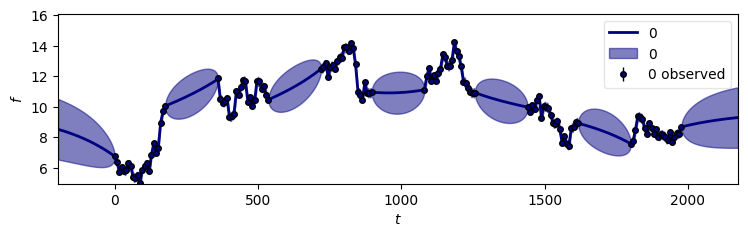

In [10]:
#Let's test this now with the example object from Javelin. 
#Run the model
c = get_data(["/Users/rjassef/Software/javelin/examples/dat/continuum.dat"])
cmod = Cont_Model(c)
cmod.do_mcmc(nwalkers=200, nchain=200)
hpd_test = cmod.hpd

#Plot the fit. 
lc_best = cmod.do_pred(cmod.hpd[1,:])
lc_best.plot(set_pred=True, obs=c)

#Save the MCMC chain
flatchain_test = cmod.flatchain

In [11]:
mean_f_test = np.mean(c.zylclist[0][1])
print(mean_f_test)

9.926770579710144


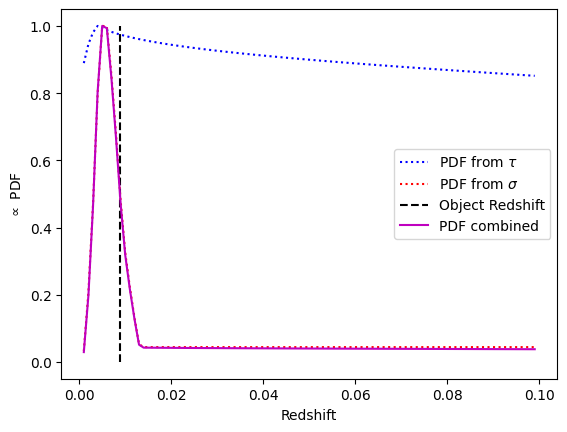

In [12]:
#Plot the results.

z_test = np.arange(0.001, 0.1, 0.001)
zsource = 0.00884

Mi_z = get_Mi_z(11., z_test)
tau_test = get_tau_M10(Mi_z, z_test) * (1+z_test)
sigma_test = get_sigma_M10(Mi_z, z_test) * 0.4*np.log(10.) * mean_f_test

dens_tau_pdf_binned, bins_tau = np.histogram(np.exp(flatchain_test[:,1]), bins=30)
tau_pdf = 0.5*(bins_tau[1:]+bins_tau[:-1])
dens_tau_pdf = np.interp(tau_test, tau_pdf, dens_tau_pdf_binned)/flatchain_test.shape[0]
plt.plot(z_test, dens_tau_pdf/np.max(dens_tau_pdf), 'b:', label=r'PDF from $\tau$')

dens_sigma_pdf_binned, bins_sigma = np.histogram(np.exp(flatchain_test[:,0]), bins=30)
sigma_pdf = 0.5*(bins_sigma[1:]+bins_sigma[:-1])
dens_sigma_pdf = np.interp(sigma_test, sigma_pdf, dens_sigma_pdf_binned)/flatchain_test.shape[0]
plt.plot(z_test, dens_sigma_pdf/np.max(dens_sigma_pdf), 'r:', label=r'PDF from $\sigma$')

plt.plot([zsource, zsource],[0.,1.], 'k--', label='Object Redshift')
plt.plot(z_test, dens_sigma_pdf*dens_tau_pdf/np.max(dens_sigma_pdf*dens_tau_pdf), 'm-', label='PDF combined')

plt.xlabel('Redshift')
plt.ylabel(r'$\propto$ PDF')

plt.legend()

plt.show()

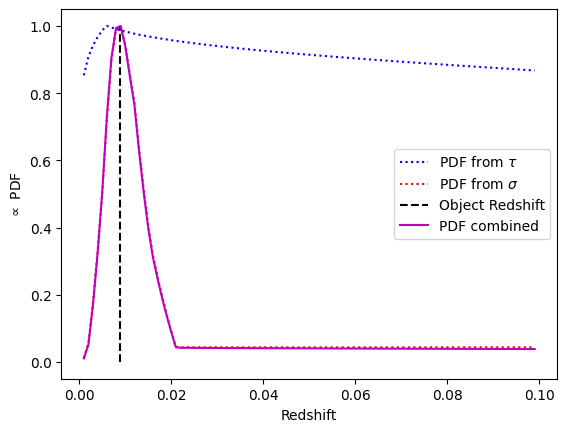

In [13]:
#Plot the results.

z_test = np.arange(0.001, 0.1, 0.001)
zsource = 0.00884

Mi_z = get_Mi_z(12., z_test)
tau_test = get_tau_M10(Mi_z, z_test) * (1+z_test)
sigma_test = get_sigma_M10(Mi_z, z_test) * 0.4*np.log(10.) * mean_f_test

dens_tau_pdf_binned, bins_tau = np.histogram(np.exp(flatchain_test[:,1]), bins=30)
tau_pdf = 0.5*(bins_tau[1:]+bins_tau[:-1])
dens_tau_pdf = np.interp(tau_test, tau_pdf, dens_tau_pdf_binned)/flatchain_test.shape[0]
plt.plot(z_test, dens_tau_pdf/np.max(dens_tau_pdf), 'b:', label=r'PDF from $\tau$')

dens_sigma_pdf_binned, bins_sigma = np.histogram(np.exp(flatchain_test[:,0]), bins=30)
sigma_pdf = 0.5*(bins_sigma[1:]+bins_sigma[:-1])
dens_sigma_pdf = np.interp(sigma_test, sigma_pdf, dens_sigma_pdf_binned)/flatchain_test.shape[0]
plt.plot(z_test, dens_sigma_pdf/np.max(dens_sigma_pdf), 'r:', label=r'PDF from $\sigma$')

plt.plot([zsource, zsource],[0.,1.], 'k--', label='Object Redshift')
plt.plot(z_test, dens_sigma_pdf*dens_tau_pdf/np.max(dens_sigma_pdf*dens_tau_pdf), 'm-', label='PDF combined')

plt.xlabel('Redshift')
plt.ylabel(r'$\propto$ PDF')

plt.legend()

plt.show()